# Re-enginering of the definition of HMM for Address Segmentation
- dataset_v4 directory for data
- contry and countryCode in dataset are not used, skip in split_good_bad_dataset function
- corrected the row 10330 in input dataset wholedataset_withshuffle.csv. AUTOSTRADA ROMA FIUMICINO becomes AUTOSTRADA ROMA-FIUMICINO to be coherent with the segmentation

In [1]:
import numpy as np
import re

In [2]:
import os
import sys

In [3]:
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.externals import joblib
from sklearn.model_selection import KFold

In [4]:
from hmmlearn.hmm import MultinomialHMM
from hmm_library import HMM
from hmm import Model

In [5]:
# input_files has 3 represents 3 different ways to write each address in the same line
# this function generates 3 lines for each input line
def prepare_dataset(input_file, output_file):
    '''
    Service function to manage the new data format provided by DoDifferent,
    splits each line in the input_file in 3 lines: 
    
    r1;r2;r3;other fields
    
    in input files becomes
    
    r1;other fields
    r2;other fields
    r3;other fields
    
    into the output_file
    ''' 
    if not os.path.exists(input_file):
        print("Input dataset file not present", input_file)
        return
    
    of = open(output_file, 'w')
    for line in open(input_file):
        elements = line.split(';')
        of.write(';'.join([elements[0]] + elements[3:]))
        of.write(';'.join([elements[1]] + elements[3:]))
        of.write(';'.join([elements[2]] + elements[3:]))

In [6]:
prepare_dataset('dataset_v4/wholedataset_withshuffle.csv', 'dataset_v4/wholedataset.csv')

In [7]:
# index2tag dictionary reflects the data structure defined in Definizione Tracciato 01_00.xlsx
# only records with returnCode=OK will be used for training (think about learning from negative examples in future)
# the tags will be used as internal states of the HMM
# country and countryCode will be discarded in the training set as they are fixed in Italy

index2tag = { 0:'inputFullAddress', 1:'streetName', 2:'streetType', 3:'houseNumber', 4:'postalCode', 
              5:'country', 6:'region', 7:'province', 8:'city', 9:'area', 10:'countryCode', 11:'regionCode',
              12:'provCode', 13:'cityCode', 14:'areaCode', 15:'returnCode'}

# search_priority is a map used to give priority to tags in the processing of each word of the inputFullAddress
# keeping the order of the columns in the input file (don't want to reorder the columns)
# basically to follow the priority order: area, city, prov, region
# 15:15 is necessary to avoid bug with case limit in the loop
search_priority = { 0:0, 1:1, 2:2, 3:3, 4:4, 5:9, 6:8, 7:7, 8:6, 9:5, 10:14, 11:13, 12:12, 13:11, 14:10, 15:15 }

# output_file is the output in the format needed for processing in HMM
# check return code OK-KO has been added in this function
# ISSUE TO SOLVE: ROMA RM AUTOSTRADA ROMA AEROPORTO DI FIUMICINO .....
def split_good_bad_dataset(input_file, good_file, bad_file, output_file):
    '''
    Service function to create the output_file in the format needed for the training of HMM
    the original input_file is split in 2 files: good_file and bad_file
    the good_file contains the rows that have been used to generate the output_file
    the bad_file contains the rows not usable for training
    further analysis could expand the good_file (and the output_file) including more records
    '''
    if not os.path.exists(input_file):
        print("Input dataset file not present", input_file)
        return
        
    count_bad = 0
    count_good = 0
    
    gf = open(good_file, 'w')
    bf = open(bad_file, 'w')
    of = open(output_file, 'w')
    
    for line in open(input_file):
        elements = line.split(';')
        
        # malformed record
        if len(elements) < 16:
            count_bad += 1
            bf.write(line)
            continue
        
        # only records with returnCode OK can be used for training
        if elements[15] != 'OK':
            count_bad += 1
            bf.write(line)
            continue
        
        inputFullAddressAsList = re.split(r'\s+', elements[0].strip())
        n_tokens = len(inputFullAddressAsList)
        
        buffer_to_write = ''
        for i in range(n_tokens):
            token = inputFullAddressAsList[i]
            for j in range(1, 16):
                k = search_priority[j]
                # avoid country (index 5) and countryCode (index 10)
                if (k != 5) and (k != 10) and (token in re.split(r'\s+', elements[k].strip())):
                    buffer_to_write = buffer_to_write + token + ' ' + index2tag[k] + '\n'
                    break
            if j == 15:
                count_bad += 1
                bf.write(line)
                break
            elif i == n_tokens-1:
                of.write(buffer_to_write + '\n')
                gf.write(line)
                count_good += 1
    
    
    print('Number of bad lines', count_bad)
    print('Number of good lines', count_good)
    
    gf.close()
    bf.close()
    of.close()

In [8]:
split_good_bad_dataset('dataset_v4/wholedataset.csv', 'dataset_v4/training_RM_OK_good.csv', 'dataset_v4/training_RM_OK_bad.csv', 
                       'dataset_v4/training_hmm.csv')


Number of bad lines 73330
Number of good lines 298670


In [9]:
def load_dataset(filename, split_sequences=False):
    if not os.path.exists(filename):
        print("Input dataset file not present", filename)
        exit()

    word2idx = {}
    tag2idx = {}
    word_idx = 0
    tag_idx = 0
    X = []
    Y = []
    currentX = []
    currentY = []
    
    # placeholder to manage unknown words in actual addresses for prediction
    word2idx['UNK'] = word_idx
    word_idx += 1
    
    # 4 placeholders to manage 5 cypher numbers (e.g. ZIP codes) in input textual address
    for i in range(4):
        word2idx['N5_' + str(i)] = word_idx
        word_idx += 1
        
    # 4 placeholders to manage other numbers (e.g. ZIP codes) in input textual address
    for i in range(4):
        word2idx['N_' + str(i)] = word_idx
        word_idx += 1
    
    number_5cypher = 0 # counter to instanciate N5 placeholders found in the actual sequence
    number_other = 0 # counter to instanciate N placeholders found in the actual sequence
    
    for line in open(filename):
        line = line.rstrip()
        if line:
            r = line.split()
            
            word, tag = r
            
            # F.P. decided to manage lowerized
            word = word.lower()
    
            # F.P. added to manage numbers
            if re.match(r'^\d{5}$', word):
                word = 'N5_' + str(number_5cypher)
                number_5cypher += 1
            elif re.match(r'^\d+$', word):
                word = 'N_' + str(number_other)
                number_other += 1
    
            if word not in word2idx:
                word2idx[word] = word_idx
                word_idx += 1
            currentX.append(word2idx[word])
            
            if tag not in tag2idx:
                tag2idx[tag] = tag_idx
                tag_idx += 1
            currentY.append(tag2idx[tag])
            
        elif split_sequences:
            X.append(currentX)
            Y.append(currentY)
            currentX = []
            currentY = []
            number_5cypher = 0 #F.P. reinitializes counters
            number_other = 0

    if not split_sequences:
        X = currentX
        Y = currentY
        
    print('The TAG dictionary is')
    print(tag2idx)

    return X, Y, word2idx, tag2idx

In [10]:
def accuracy(T, Y):
    # inputs are lists of lists
    n_correct = 0
    n_total = 0
    for t, y in zip(T, Y):
        n_correct += np.sum(t == y)
        n_total += len(y)
        
    print('N correct =', n_correct)
    print('N total =', n_total)
    return float(n_correct) / n_total

In [11]:
def total_f1_score(T, Y):
    # inputs are lists of lists
    T = np.concatenate(T)
    Y = np.concatenate(Y)
    print('T =', T)
    print('Y =', Y)
    print('Detailed f1: ', f1_score(T, Y, average=None))
    
    return f1_score(T, Y, average=None).mean()

In [12]:
def total_recall_score(T, Y):
    # inputs are lists of lists
    T = np.concatenate(T)
    Y = np.concatenate(Y)
    print('T =', T)
    print('Y =', Y)
    print('Detailed Recall: ', recall_score(T, Y, average=None))
    return recall_score(T, Y, average=None).mean()

In [13]:
def total_f1_kfold(T, Y):
    # inputs are lists of lists
    T = np.concatenate(T)
    Y = np.concatenate(Y)
    print('T =', T)
    print('Y =', Y)
    print('Detailed f1: ', f1_score(T, Y, average=None))
    
    return f1_score(T, Y, average=None).mean()

In [14]:
def total_precision_score(T, Y):
    # inputs are lists of lists
    T = np.concatenate(T)
    Y = np.concatenate(Y)
    print('T =', T)
    print('Y =', Y)
    print('Detailed precision: ', precision_score(T, Y, average=None))
    return precision_score(T, Y, average=None).mean()

In [15]:
#print("Test Accuracy: {}".format(accuracy(Y, X)))

In [16]:
def create_hmm_model_kfold(smoothing=1e-3):
    X, Y, word2idx, tag2idx = load_dataset('dataset_v4/training_hmm.csv', split_sequences=True)
    X, Y = shuffle(X, Y)
    X = np.array(X)
    Y = np.array(Y)
    print('Samples in whole dataset =', len(X), len(Y))
    V = len(word2idx)
    print('V =', V)
    print()

    # find hidden state transition matrix and pi
    M = len(tag2idx)
    print('M =', M)
    
    A = np.ones((M, M))#*smoothing # add-one smoothing
    pi = np.zeros(M)
    
    # observation matrix
    B = np.ones((M, V))*smoothing # add-one smoothing
    #print(B)
    kf = KFold(n_splits = 5, shuffle = True)
    sum_acc_train = 0
    sum_acc_test = 0
    sum_f1_score_train = 0
    sum_f1_score_test = 0
    counter = 0
    for train_ind, test_ind in kf.split(X):
        Xtrain, Xtest = X[train_ind], X[test_ind]
        Ytrain, Ytest = Y[train_ind], Y[test_ind]
        
        for y in Ytrain:
            pi[y[0]] += 1
            for i in range(len(y)-1):
                A[y[i], y[i+1]] += 1
        
        A /= A.sum(axis=1, keepdims=True)
        pi /= pi.sum()
        
        
        for x, y in zip(Xtrain, Ytrain):
            for xi, yi in zip(x, y):
                B[yi, xi] += 1    # Do Absolute discounting here 
            #else:
            #    B[yi, xi] += 0.01
        B /= B.sum(axis=1, keepdims=True)
        hmm = MultinomialHMM(M, verbose = False, n_iter = 1, tol = .1)
        hmm.startprob_ = pi
        hmm.transmat_ = A
        hmm.emissionprob_ = B
        
        Ptrain = []
        for x in Xtrain:
            p = (hmm.decode(np.array([x]).T))[1] # F.P. this method can be used to tag a new address
            Ptrain.append(p)
            #print(len(Ptrain))
        Ptest = []
        for x in Xtest:
            p = (hmm.decode(np.array([x]).T))[1]
            Ptest.append(p)
        # print results
        sum_acc_train += accuracy(Ytrain, Ptrain)
        sum_acc_test += accuracy(Ytest, Ptest)
        sum_f1_score_train += total_f1_score(Ytrain, Ptrain)
        sum_f1_score_test += total_f1_score(Ytest, Ptest)
        counter += 1
        print("RUN NOW IS: {} OF 10".format(counter))
    print("train accuracy: {}".format(sum_acc_train/5))
    print("test accuracy: {}".format(sum_acc_test/5))
    print("train F1_score: {}".format(sum_f1_score_train/5))
    print("test F1_score: {}".format(sum_f1_score_test/5))
    
    return hmm, word2idx, tag2idx      

In [ ]:
address_segmentator, word2idx, tag2idx = create_hmm_model_kfold()
#address_segmentator, word2idx, tag2idx = create_hmm_model_kfold_sm(smoothing=1e-1)
#model, word2idx, tag2idx = load_dataset('dataset_v4/training_hmm.csv', split_sequences=True)

The TAG dictionary is
{'houseNumber': 0, 'streetType': 1, 'streetName': 2, 'postalCode': 3, 'city': 4, 'provCode': 5, 'area': 6}
Samples in whole dataset = 298670 298670
V = 13745

M = 7


/home/gift/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),


In [ ]:
#word2idx

In [87]:
c1 = 0
c2 = 0
for x, y in zip(X, Y):
    #print(4)
    x = set(x)
    y = set(y)
    if(len(x-y) == 0):
        c1 = c1+1
    else:
        c2 = c2+1
print(c1/len(X))

0.9932


In [16]:
#address_segmentator, word2idx, tag2idx = create_hmm_model()
#print(word2idx)


In [19]:
#word2idx

In [ ]:
#tag2idx

In [21]:
def segment(model, word2index, tag2index, address):
    
    index2tag = {}
    for tag in tag2index:
        index2tag[tag2index[tag]] = tag
    
    number_5cypher = 0 # counter to instanciate N5 placeholders found in the actual sequence
    number_other = 0 # counter to instanciate N placeholders found in the actual sequence
    
    address_words = re.split(r'\s+', address.strip())

    x = []
    for word in address_words:
        word = word.lower()
        if word in word2index:
            x.append(word2index[word])
        elif re.match(r'^\d{5}$', word):
            x.append(word2index['N5_' + str(number_5cypher)])
            number_5cypher +=1
        elif re.match(r'^\d+$', word):
            x.append(word2index['N_' + str(number_other)])
            number_other += 1
        else:     
            x.append(word2index['UNK'])
    
    print(x)
    
    state_sequence = (model.decode(np.array([x]).T))[1]
    print(state_sequence)
    
    for i in range(len(x)):
        print(address_words[i], index2tag[state_sequence[i]])
        


In [22]:
re.split(r'\s+', 'via delle archeologia 29 00133 RM'.strip())

['via', 'delle', 'archeologia', '29', '00133', 'RM']

In [26]:
segment(address_segmentator, word2idx, tag2idx, 'via del archeologia 29 00133 RM')

[16, 50, 0, 5, 1, 13]
[1 2 6 0 3 5]
via streetType
del streetName
archeologia area
29 houseNumber
00133 postalCode
RM provCode


/home/gift/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),


In [110]:
joblib.dump(address_segmentator, 'model_v4/address_segmentator.pkl')

['model_v4/address_segmentator.pkl']

In [29]:
joblib.dump(word2idx, 'model_v4/word2idx.pkl')

['model_v4/word2idx.pkl']

In [30]:
joblib.dump(tag2idx, 'model_v4/tag2idx.pkl')

['model_v4/tag2idx.pkl']

In [31]:
import logging
import codecs
import time
import sys

import numpy as np
import re

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.externals import joblib

# logging object is shared between module, the first initialization is effective
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

from flask import Flask, jsonify, request

LOG_FILE = './Address_Segmentator.log' # Not used yet

application = Flask(__name__)

def inference():
  logger.info('Address segmentator: loading config')

  address_segmentator = joblib.load('model_v4/address_segmentator.pkl')
  word2index = joblib.load('model_v4/word2idx.pkl')
  tag2index = joblib.load('model_v4/tag2idx.pkl')

  index2tag = {}
  for tag in tag2index:
    index2tag[tag2index[tag]] = tag

  def segment(address):
    number_5cypher = 0 # counter to instanciate N5 placeholders found in the actual sequence
    number_other = 0 # counter to instanciate N placeholders found in the actual sequence
    address_words = re.split(r'\s+', address.strip())

    x = []
    for word in address_words:
      word = word.lower()
      if word in word2index:
        x.append(word2index[word])
      elif re.match(r'^\d{5}$', word):
        x.append(word2index['N5_' + str(number_5cypher)])
        number_5cypher +=1
      elif re.match(r'^\d+$', word):
        x.append(word2index['N_' + str(number_other)])
        number_other += 1
      else:
        x.append(word2index['UNK'])

    state_sequence = (address_segmentator.decode(np.array([x]).T))[1]

    segmented_address = {}
    for i in range(len(x)):
      segmented_address[index2tag[state_sequence[i]]] = segmented_address.get(index2tag[state_sequence[i]], '') + address_words[i] + ' '

    return segmented_address

  @application.route('/decode/v0.0', methods=['GET'])
  def decode():
    query = str(request.args.get('query')) # str convert None as string
    
    return jsonify(segment(query))

  @application.route('/nl2sql/v0.0/set_log_level', methods=['GET'])
  def set_log_level():
    log_level = request.args.get('log_level')
    if log_level == 'INFO':
      logger.setLevel(logging.INFO)
      return jsonify('Nl2sql: log level set to INFO')
    elif log_level == 'DEBUG':
      logger.setLevel(logging.DEBUG)
      return jsonify('Nl2sql: log level set to DEBUG')

    return jsonify('Nl2sql: unsupported or missing log level')

logger.info('Address Segmentator: creating endpoints')
inference()

if __name__ == '__main__':
  logger.info('Address Segmentator: starting')
  application.run(host='127.0.0.1', port=5002, debug=True, use_reloader=True)
  #application.exit()

2018-11-28 13:01:36,109 - __main__ - INFO - Address Segmentator: creating endpoints
2018-11-28 13:01:36,110 - __main__ - INFO - Address segmentator: loading config
2018-11-28 13:01:36,293 - __main__ - INFO - Address Segmentator: starting
2018-11-28 13:01:36,453 - werkzeug - INFO -  * Running on http://127.0.0.1:5002/ (Press CTRL+C to quit)
2018-11-28 13:01:36,479 - werkzeug - INFO -  * Restarting with stat


SystemExit: 1

/home/gift/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [98]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [199]:
num_epochs = 100
total_series_length = 298670
truncated_backprop_length = 15
state_size = 4
num_classes = 7
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [300]:
def generateData():
    X, Y, word2idx, tag2idx = load_dataset('dataset_v4/training_hmm.csv', split_sequences=True)
    
    X =np.array([x[0] for x in X])
    
    Y = np.array([x[0] for x in Y])
    X = X.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    Y = Y.reshape((batch_size, -1)) 
    return (X, Y)

In [301]:
X, Y = generateData()
print(len(Y))


The TAG dictionary is
{'houseNumber': 0, 'streetType': 1, 'streetName': 2, 'postalCode': 3, 'city': 4, 'provCode': 5, 'area': 6}
5


In [302]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])
print(init_state)

Tensor("Placeholder_44:0", shape=(5, 4), dtype=float32)


In [303]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [304]:
# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [305]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

In [306]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [307]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
plt.pause(0.0001)

The TAG dictionary is
{'houseNumber': 0, 'streetType': 1, 'streetName': 2, 'postalCode': 3, 'city': 4, 'provCode': 5, 'area': 6}
New data, epoch 0
Step 0 Loss 1.71384
Step 100 Loss 1.10768
Step 200 Loss 1.09784
Step 300 Loss 1.10796
Step 400 Loss 1.101
Step 500 Loss 1.10591
Step 600 Loss 1.38184
Step 700 Loss 1.10777
Step 800 Loss 1.10117
Step 900 Loss 1.1005
Step 1000 Loss 1.10475
Step 1100 Loss 1.1018
Step 1200 Loss 1.09618
Step 1300 Loss 1.09976
Step 1400 Loss 1.1025
Step 1500 Loss 1.10267
Step 1600 Loss 1.09934
Step 1700 Loss 1.10042
Step 1800 Loss 1.10039
Step 1900 Loss 1.10033
Step 2000 Loss 1.09229
Step 2100 Loss 0.421653
Step 2200 Loss 0.507995
Step 2300 Loss 0.481491
Step 2400 Loss 0.367996
Step 2500 Loss 0.282211
Step 2600 Loss 0.505718
Step 2700 Loss 0.425336
Step 2800 Loss 0.263565
Step 2900 Loss 0.319644
Step 3000 Loss 0.489506
Step 3100 Loss 0.22281
Step 3200 Loss 0.235785
Step 3300 Loss 0.465532
Step 3400 Loss 0.140014
Step 3500 Loss 0.261344
Step 3600 Loss 0.163634
Step

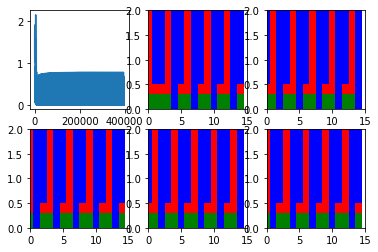

In [308]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = np.array(x)[:,start_idx:end_idx]
            batchY = np.array(y)[:,start_idx:end_idx]
            
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })
            
            loss_list.append(_total_loss)
            
            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)
            

#plt.ioff()
#plt.show()

In [309]:
plt.ioff()
plt.show()

In [ ]:
def create_hmm_model_kfold_sm(smoothing=1e-3):
    X, Y, word2idx, tag2idx = load_dataset('dataset_v4/training_hmm.csv', split_sequences=True)
    X, Y = shuffle(X, Y)
    X = np.array(X)
    Y = np.array(Y)
    print('Samples in whole dataset =', len(X), len(Y))
    V = len(word2idx)
    print('V =', V)
    
    # find hidden state transition matrix and pi
    M = len(tag2idx)
    print('M =', M)
    states = set([str(i) for i in range(len(tag2idx))])
    symbols = set([str(s) for key, s in word2idx.items()])
    A = np.ones((M, M))*smoothing # add-one smoothing
    pi = np.zeros(M)
    
    # observation matrix
    B = np.ones((M, V))*smoothing # add-one smoothing
    #print(B)
    kf = KFold(n_splits = 10, shuffle = True)
    sum_acc_train = 0
    sum_acc_test = 0
    sum_f1_score_train = 0
    sum_f1_score_test = 0
    counter = 0
    for train_ind, test_ind in kf.split(X):
        Xtrain, Xtest = X[train_ind], X[test_ind]
        Ytrain, Ytest = Y[train_ind], Y[test_ind]
        
        for y in Ytrain:
            pi[y[0]] += 1
            for i in range(len(y)-1):
                A[y[i], y[i+1]] += 1
        
        A /= A.sum(axis=1, keepdims=True)
        pi /= pi.sum()
        
        
        for x, y in zip(Xtrain, Ytrain):
            for xi, yi in zip(x, y):
                B[yi, xi] += 1    # Do Absolute discounting here 
            else:
                B[yi, xi] = 0.001
        B /= B.sum(axis=1, keepdims=True)
        hmm = Model(states, symbols)
        hmm._start_prob = pi
        hmm._trans_prob = A
        hmm._emit_prob = B

        
        Ptrain = []
        for x in Xtrain:
            x = [str(i) for i in x]
            p = hmm.decode(np.array(x)) # F.P. this method can be used to tag a new address
            Ptrain.append(p)
            #print(len(Ptrain))
        Ptest = []
        for x in Xtest:
            x = [str(i) for i in x]
            p = hmm.decode(np.array(x))
            Ptest.append(p)
        # print results
        sum_acc_train += accuracy(Ytrain, Ptrain)
        sum_acc_test += accuracy(Ytest, Ptest)
        sum_f1_score_train += total_f1_score(Ytrain, Ptrain)
        sum_f1_score_test += total_f1_score(Ytest, Ptest)
        counter += 1
        print("RUN NOW IS: {} OF 10".format(counter))
    print("train accuracy: {}".format(sum_acc_train/10))
    print("test accuracy: {}".format(sum_acc_test/10))
    print("train F1_score: {}".format(sum_f1_score_train/10))
    print("test F1_score: {}".format(sum_f1_score_test/10))
    
    return hmm, word2idx, tag2idx      

In [33]:
python OpenNMT-py/preprocess.py \
 -train_src data/src-train.txt \
 -train_tgt data/tgt-train.txt \
 -valid_src data/src-val.txt \
 -valid_tgt data/tgt-val.txt \
 -save_data data/train/preprocessed 

4


In [ ]:
python -u train.py \
 -save_model data/train/models_v2/ \
 -data data/train/preprocessed \
 -global_attention mlp \
 -word_vec_size 13745 \
 -rnn_size 512 \
 -layers 4 \
 -encoder_type brnn \
 -train_steps 50000 \
 -report_every 10000 \
 -valid_steps 5000 \
 -valid_batch_size 64 \
 -max_generator_batches 128 \
 -save_checkpoint_steps 10000 \
 -max_grad_norm 2 \
 -dropout 0.1 \
 -batch_size 16 \
 -optim adagrad \
 -learning_rate 0.15 \
 -start_decay_steps 10000 \
 -decay_steps 1000 \
 -adagrad_accumulator_init 0.1 \
 -copy_loss_by_seqlength \
 -bridge \
 -seed 919 \
 -log_file train.v2.log

In [ ]:
mkdir nmt_model
python -m nmt.nmt \
    -src=en --tgt=vi \
    -vocab_prefix= /home/gift/Pictures/nmt/nmt/NMT_data/vocab  \
    -train_prefix= /home/gift/Pictures/nmt/nmt/NMT_data/train \
    -dev_prefix=/home/gift/Pictures/nmt/nmt/NMT_data/tst2012  \
    --test_prefix=/home/gift/Pictures/nmt/nmt/NMT_data/tst2013 \
    --out_dir=nmt_model \
    --num_train_steps=12000 \
    --steps_per_stats=100 \
    --num_layers=2 \
    --num_units=128 \
    --dropout=0.2 \
    --metrics=bleu
    

In [ ]:
python -m nmt.nmt \
    --src=en --tgt=vi \
    --vocab_prefix=/tmp/nmt_data/vocab \
    --train_prefix=/tmp/nmt_data/train \
    --dev_prefix=/tmp/nmt_data/tst2012 \
    --test_prefix=/tmp/nmt_data/tst2013 \ 
    -out_dir=/tmp/nmt_model \
    -num_train_steps=12000 \   
    -steps_per_stats=100  \   
    -num_layers=6 \
    -num_units=128 \
    -dropout=0.2 \
    -log_file train.v2.log \
    -metrics=bleu
